Using all the previously trained models as an ensemble

Got 0.67807

In [1]:
import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'confi

In [2]:
os.environ['KERAS_BACKEND'] = 'theano'
# TODO: Use float16 ?
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
import keras
from keras.layers import Input, Dense, Dropout, Activation, Flatten, merge, RepeatVector, Permute, Reshape
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, MaxoutDense
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.utils.layer_utils import print_summary
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 4007)


In [3]:
from keras.layers import Layer, InputSpec
import keras.initializations
import keras.backend as K

class Maxout2D(Layer):
    def __init__(self, output_dim, cardinality, init='glorot_uniform', **kwargs):
        super(Maxout2D, self).__init__(**kwargs)
        # the k of the maxout paper
        self.cardinality = cardinality
        # the m of the maxout paper
        self.output_dim = output_dim
        self.init = keras.initializations.get(init)
    
    def build(self, input_shape):
        self.input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_shape[1], input_shape[2], input_shape[3]))]
        self.W = self.init((self.input_dim, self.output_dim, self.cardinality),
                           name='{}_W'.format(self.name))
        self.b = K.zeros((self.output_dim, self.cardinality))
        self.trainable_weights = [self.W, self.b]
              
    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        # flatten the spatial dimensions
        flat_x = K.reshape(x, (-1, input_shape[1], input_shape[2] * input_shape[3]))
        output = K.dot(
            K.permute_dimensions(flat_x, (0, 2, 1)),
            K.permute_dimensions(self.W, (1, 0, 2))
        )
        output += K.reshape(self.b, (1, 1, self.output_dim, self.cardinality))
        output = K.max(output, axis=3)
        output = output.transpose(0, 2, 1)
        output = K.reshape(output, (-1, self.output_dim, input_shape[2], input_shape[3]))
        return output
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.output_dim, input_shape[2], input_shape[3])
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'cardinality': self.cardinality
        }
        base_config = super(Maxout2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X = _d['X'][:,None,:,:]
Y = _d['Y'][:,None,:,:]

sub29 is with sub28

In [5]:
models_dir = ['fcnn_maxout.sub10', 'sub13', 'sub19', 'sub21', 'sub25', 'sub26', 'sub28']
models_dir = [os.path.join('../models', d) for d in models_dir]
#models_dir = models_dir[:2]

In [6]:
def load_from_dir(model_dir):
    model = model_from_json(
        open(os.path.join(model_dir, 'architecture.json')).read(),
        custom_objects={'Maxout2D' : Maxout2D}
    )
    model.load_weights(os.path.join(model_dir, 'weights.hdf5'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                  loss_weights=[1., 0.01])
    return model

In [7]:
models = [load_from_dir(d) for d in models_dir]

In [8]:
for m in models:
    assert len(m.output_layers) == 2

In [9]:
Y_preds = []
Y_preds_binary = []
for i, m in enumerate(models):
    print '\r%d / %d' % (i, len(models)),
    sys.stdout.flush()
    
    Y_pred, Y_pred_binary = m.predict(X)
    Y_pred = Y_pred.astype(np.float32)
    Y_pred_binary = Y_pred_binary.astype(np.float32)
    
    Y_preds.append(Y_pred)
    Y_preds_binary.append(Y_pred_binary)
    
Y_preds = np.array(Y_preds)
Y_preds_binary = np.array(Y_preds_binary)

6 / 7


In [10]:
Y_preds_binary = Y_preds_binary.astype(np.float32)

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


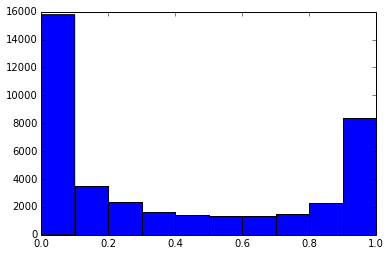

In [11]:
_ = pl.hist(Y_preds_binary.ravel())

In [12]:
# Check out the images with most disagreement
if False:
    disagreement = np.std(Y_preds_binary.squeeze(), axis=0)
    disagreement = np.argsort(disagreement)[::-1]

    #i = 50
    #i = 47

    #for i in lowest[380:385]:
    for i in disagreement[:5]:
        pl.figure(figsize=(12, 3))
        pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y[i]))
        pl.subplot(141)
        pl.title('input')
        pl.imshow(X[i].squeeze())
        pl.subplot(142)
        pl.title('expected')
        pl.imshow(Y[i].squeeze())
        pl.subplot(143)
        pl.title('predicted')
        pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
        pl.subplot(144)
        #print np.sum(Y_pred[i].squeeze())
        pl.title('prediction proba %s' % str(Y_preds_binary[:,i].squeeze()))
        pl.imshow(np.mean(Y_preds[:,i], axis=0).squeeze(), vmin=0, vmax=1)

In [13]:
Y_pred = np.mean(Y_preds, axis=0)
Y_pred_binary = np.mean(Y_preds_binary, axis=0)

Best map_thresh=0.300000, bin_thresh=0.500000


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


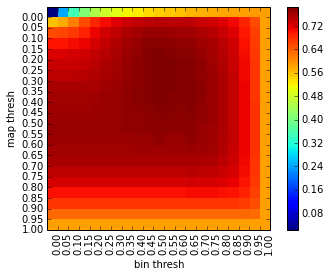

In [14]:
def compute_scores_map():
    map_threshs = np.linspace(0, 1, num=21)
    bin_threshs = np.linspace(0, 1, num=21)
    
    scores = np.zeros((len(map_threshs), len(bin_threshs)))
    for i in range(len(map_threshs)):
        for j in range(len(bin_threshs)):
            _Y_pred = Y_pred > map_threshs[i]
            
            for k in range(_Y_pred.shape[0]):
                # Clear prediction where we detect to little pixels
                if np.sum(_Y_pred[k]) < 150 or Y_pred_binary[k] < bin_threshs[j]:
                    _Y_pred[k,:] = 0
            
            scores[i, j] = utils.average_dice_coefficient(_Y_pred, Y)
    
    pl.imshow(scores, interpolation='nearest')
    pl.yticks(np.arange(len(map_threshs)) + 0.5, ['%.2f' % v for v in map_threshs])
    pl.xticks(np.arange(len(bin_threshs)) + 0.5, ['%.2f' % v for v in bin_threshs], rotation=90)
    pl.ylabel('map thresh')
    pl.xlabel('bin thresh')
    pl.colorbar()
    
    best_i, best_j = np.unravel_index(np.argmax(scores.ravel()), scores.shape)
    best_map_thresh = map_threshs[best_i]
    best_bin_thresh = bin_threshs[best_j]
    return best_map_thresh, best_bin_thresh

map_thresh, bin_thresh = compute_scores_map()
print 'Best map_thresh=%f, bin_thresh=%f' % (map_thresh, bin_thresh)

In [19]:
map_thresh = 0.3
bin_thresh = 0.7

Y_pred = np.mean(Y_preds, axis=0) > map_thresh
Y_pred_binary = np.mean(Y_preds_binary, axis=0)

for i in range(Y_pred.shape[0]):
    if np.sum(Y_pred[i]) < 150 or Y_pred_binary[i] < bin_thresh:
        Y_pred[i,:] = 0
        
print "score : ", utils.dice_coefficient(Y_pred, Y)
print "avg score : ", utils.average_dice_coefficient(Y_pred, Y)

score :  0.631821864165
avg score :  0.773587443419


In [20]:
# Find the images with lowest scores
dice_scores = []
for i in range(Y_pred.shape[0]):
    dice_scores.append(utils.dice_coefficient(Y_pred[i], Y[i]))
dice_scores = np.array(dice_scores)
lowest = np.argsort(dice_scores)

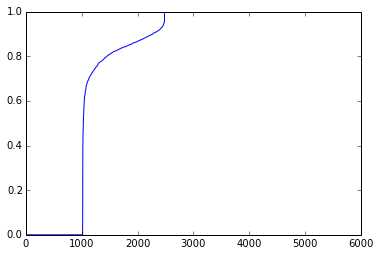

In [21]:
pl.plot(dice_scores[lowest])
#pl.plot(Y_pred_binary[lowest], c='r')

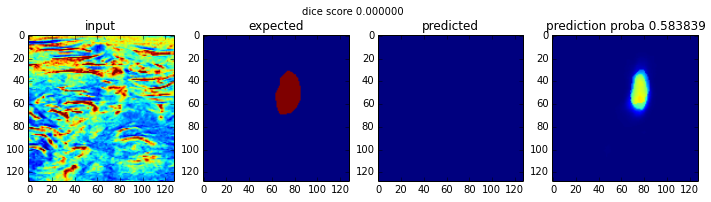

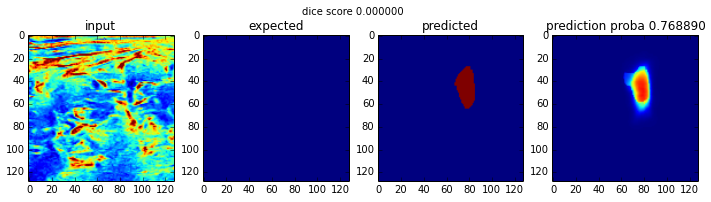

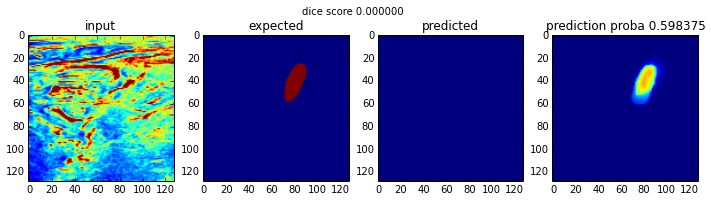

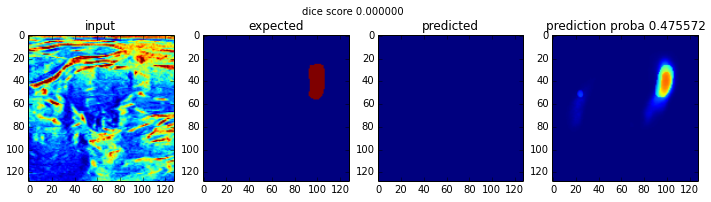

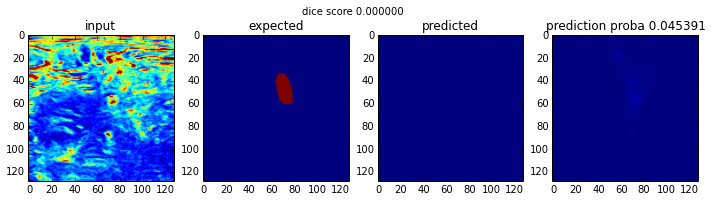

In [22]:
#i = 50
#i = 47

#for i in lowest[380:385]:
for i in lowest[210:215]:
    pl.figure(figsize=(12, 3))
    pl.suptitle('dice score %f' % utils.dice_coefficient(Y_pred[i], Y[i]))
    pl.subplot(141)
    pl.title('input')
    pl.imshow(X[i].squeeze())
    pl.subplot(142)
    pl.title('expected')
    pl.imshow(Y[i].squeeze())
    pl.subplot(143)
    pl.title('predicted')
    pl.imshow(Y_pred[i].squeeze(), vmin=0, vmax=1)
    pl.subplot(144)
    #print np.sum(Y_pred[i].squeeze())
    pl.title('prediction proba %f' % Y_pred_binary[i])
    pl.imshow(np.mean(Y_preds[:,i], axis=0).squeeze(), vmin=0, vmax=1)

# Run on kaggle's test set

In [23]:
def predict(X, map_thresh, bin_thresh):
    # -- Predict using each model
    Y_preds = []
    Y_preds_binary = []
    for i, m in enumerate(models):
        print '\r%d / %d' % (i, len(models)),
        sys.stdout.flush()

        Y_pred, Y_pred_binary = m.predict(X)
        Y_pred = Y_pred.astype(np.float32)
        Y_pred_binary = Y_pred_binary.astype(np.float32)

        Y_preds.append(Y_pred)
        Y_preds_binary.append(Y_pred_binary)

    Y_preds = np.array(Y_preds)
    Y_preds_binary = np.array(Y_preds_binary)
    
    # Averaging and global thresholding
    Y_pred = np.mean(Y_preds, axis=0) > map_thresh
    Y_pred_binary = np.mean(Y_preds_binary, axis=0)

    for i in range(Y_pred.shape[0]):
        if np.sum(Y_pred[i]) < 150 or Y_pred_binary[i] < bin_thresh:
            Y_pred[i,:] = 0
    return Y_pred

In [24]:
if True:
    import cv2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(50,50))
    
    _d = np.load('../data/data_128_test.npz')
    X_submit = _d['X']
    test_fnames = _d['test_fnames']
    # bin_thresh
    Y_pred = predict(X_submit[:,None,:,:], map_thresh, bin_thresh)
    
    OUTDIR='../../preds'
    if os.path.exists(OUTDIR):
        shutil.rmtree(OUTDIR)
    utils.mkdir_p(OUTDIR)

    for i in range(Y_pred.shape[0]):
        imre = cv2.resize((Y_pred[i].squeeze() * 255).astype(np.uint8), (580, 420))
        #imre = cv2.morphologyEx(imre, cv2.MORPH_CLOSE, kernel)
        basename = os.path.splitext(test_fnames[i])[0]
        cv2.imwrite(os.path.join(OUTDIR, basename + '.png'), imre)
        
        if i % 10 == 0:
            print '\r%d / %d' % (i, len(test_fnames)),
            sys.stdout.flush()

5500 / 5508


## Stats on predicted masks

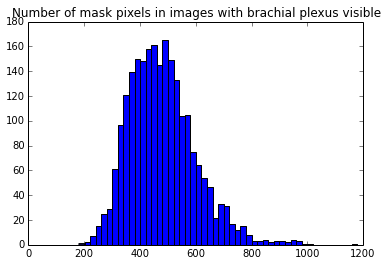

In [25]:
# on Y_full
nbp_pixels = np.sum(np.sum(np.sum(Y, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)

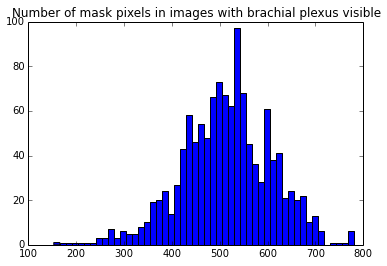

In [26]:
# on pred
nbp_pixels = np.sum(np.sum(np.sum(Y_pred, axis=1), axis=1), axis=1)
bpvisible = nbp_pixels > 0

pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)